# __Final Project: Adding captions to your photos__

__Install__

```sh
pip install kaggle
```

__Download__

```sh
kaggle datasets download -d adityajn105/flickr8k
```

__Extract__

```sh
tar -xf flickr8k.zip
```
```

### __Libraries__

In [1]:
import os
import pandas as pd
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torchvision.models as models
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import random
from torchvision.models import Inception_V3_Weights

spacy_eng = spacy.load("en_core_web_sm")

### __Vocabulary Creation__

In [2]:
###########################################################
# Vocabulary
###########################################################
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

### __Dataset & Dataloader Creation__

In [3]:
###########################################################
# Dataset & Dataloader
###########################################################
class FlickrDataset(Dataset):
    def __init__(self, root_dir, df, transform=None, freq_threshold=5, vocab=None):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform

        self.imgs = self.df["image"].values
        self.captions = self.df["caption"].values

        # If vocab not given, build it (for training)
        if vocab is None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.captions.tolist())
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        # Compute lengths on CPU
        lengths = [len(t) for t in targets.permute(1,0)]
        lengths_cpu = torch.tensor(lengths, dtype=torch.int64)

        return imgs, targets, lengths_cpu

def get_loader(root_folder, df, vocab=None, transform=None, batch_size=32, num_workers=0, shuffle=True, pin_memory=False):
    dataset = FlickrDataset(root_folder, df, transform=transform, vocab=vocab)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader, dataset

### __CNN + LSTM Architecture__

In [4]:
###########################################################
# Models
###########################################################
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        output = self.inception(images)
        # Check if output is a tuple or not
        if isinstance(output, tuple):
            # Training mode: main_output and aux_output
            features, aux_features = output
        else:
            # Eval mode: only main output
            features = output

        features = self.dropout(self.relu(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions[:-1]) # teacher forcing
        return outputs

    def caption_image(self, image, vocab, max_length=50):
        result_caption = []
        device = image.device
        with torch.no_grad():
            # Ensure image is batched
            if image.dim() == 3:
                image = image.unsqueeze(0)
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocab.itos[predicted.item()] == "<EOS>":
                    break

        return [vocab.itos[idx] for idx in result_caption]

### __BLEU Evaluation__

In [5]:
###########################################################
# BLEU Evaluation
###########################################################
def evaluate_bleu_score(model, loader, vocab, device, sample_size=100):
    model.eval()
    references = []
    candidates = []
    chencherry = SmoothingFunction()

    sampled_indices = random.sample(range(len(loader.dataset)), min(sample_size, len(loader.dataset)))

    for idx in sampled_indices:
        img, caption = loader.dataset[idx]
        # Move to device and batchify
        img = img.unsqueeze(0).to(device)
        ref = caption.tolist()
        ref_tokens = [vocab.itos[tok] for tok in ref if tok not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]
        references.append([ref_tokens])

        with torch.no_grad():
            pred = model.caption_image(img, vocab)
        pred_tokens = [w for w in pred if w not in ["<EOS>", "<PAD>"]]
        candidates.append(pred_tokens)

    bleu = corpus_bleu(references, candidates, smoothing_function=chencherry.method1)
    return bleu

### __Training the Model & Sample Image Captions__

Epoch [1/10], Loss: 3.8459
Train BLEU: 0.0344, Val BLEU: 0.0080
Model improved and saved.
Epoch [2/10], Loss: 3.2114
Train BLEU: 0.0243, Val BLEU: 0.0238
Model improved and saved.
Epoch [3/10], Loss: 3.0185
Train BLEU: 0.0275, Val BLEU: 0.0245
Model improved and saved.
Epoch [4/10], Loss: 2.8964
Train BLEU: 0.0186, Val BLEU: 0.0174
Epoch [5/10], Loss: 2.8086
Train BLEU: 0.0298, Val BLEU: 0.0204
Epoch [6/10], Loss: 2.7382
Train BLEU: 0.0280, Val BLEU: 0.0278
Model improved and saved.
Epoch [7/10], Loss: 2.6827
Train BLEU: 0.0069, Val BLEU: 0.0112
Epoch [8/10], Loss: 2.6345
Train BLEU: 0.0163, Val BLEU: 0.0145
Epoch [9/10], Loss: 2.5921
Train BLEU: 0.0261, Val BLEU: 0.0338
Model improved and saved.
Epoch [10/10], Loss: 2.5554
Train BLEU: 0.0180, Val BLEU: 0.0264


C:\Users\yashh\AppData\Local\Temp\ipykernel_83096\483791969.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test BLEU Score: 0.02693320172052895


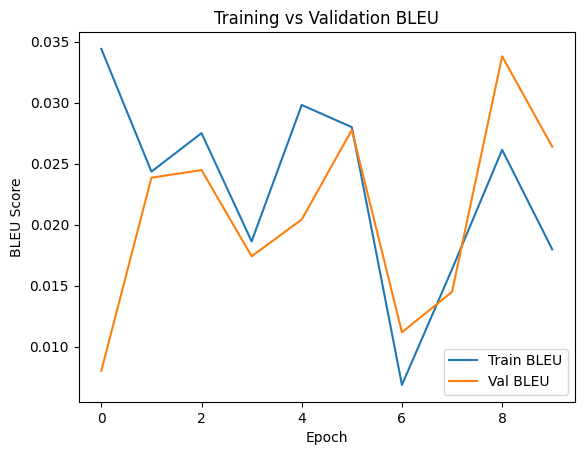

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


Predicted Caption: <SOS> a man in a black shirt is standing in front of a crowd of people .
Reference Caption: a woman and a man pose with <UNK> <UNK> <UNK> .


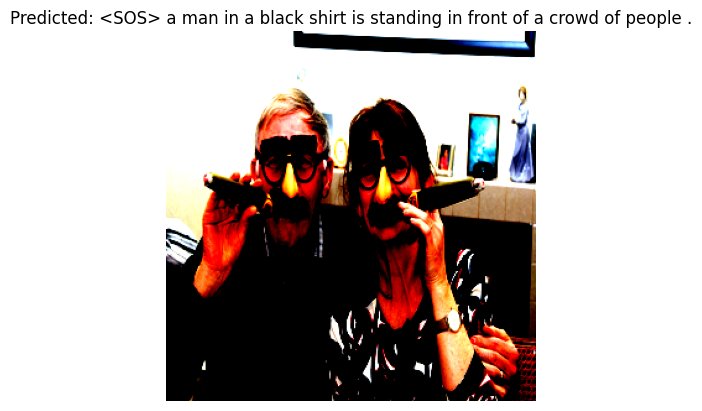

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.622571].


Predicted Caption: <SOS> a man in a blue shirt is standing on a rock in the snow .
Reference Caption: a black dog runs through surf on a sandy beach .


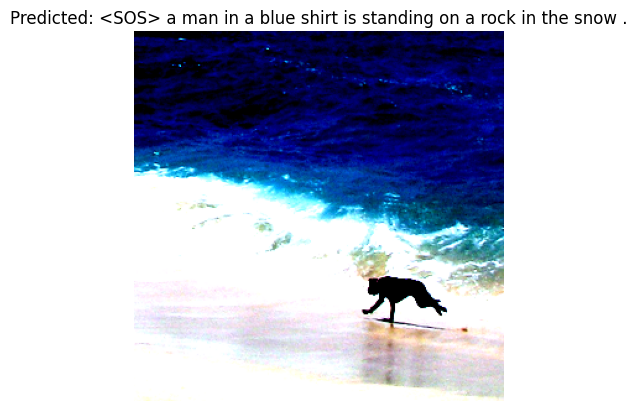

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5877128].


Predicted Caption: <SOS> a man in a blue shirt is standing on a rock in the snow .
Reference Caption: a skier making a sharp turn on a slope .


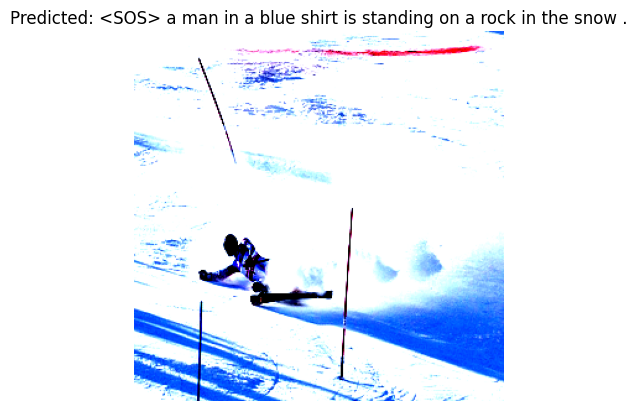

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Caption: <SOS> a man in a blue shirt is standing on a sidewalk .
Reference Caption: an old woman sits in a <UNK> station next to a <UNK> advertisement .


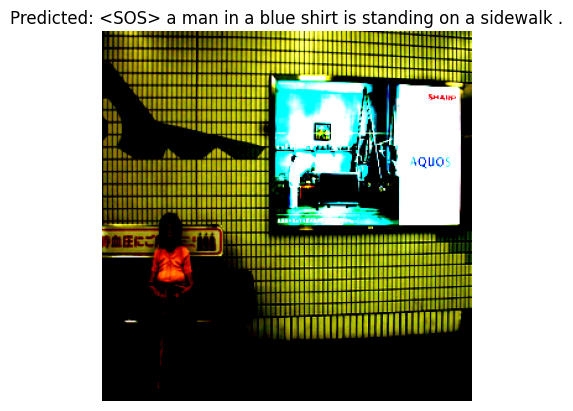

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Caption: <SOS> a dog is running through the snow .
Reference Caption: a brown dog walks through snow .


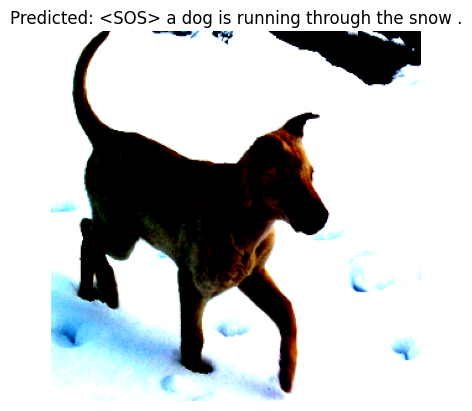

In [6]:
###########################################################
# Training / Data Splits
###########################################################
full_df = pd.read_csv("captions.txt")
unique_images = full_df['image'].unique()
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

train_df = full_df[full_df['image'].isin(train_images)].reset_index(drop=True)
val_df = full_df[full_df['image'].isin(val_images)].reset_index(drop=True)
test_df = full_df[full_df['image'].isin(test_images)].reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

temp_dataset = FlickrDataset("Images/", train_df, transform=transform)
vocab = temp_dataset.vocab

train_loader, _ = get_loader("Images/", train_df, vocab=vocab, transform=transform, batch_size=32)
val_loader, _ = get_loader("Images/", val_df, vocab=vocab, transform=transform, batch_size=32, shuffle=False)
test_loader, _ = get_loader("Images/", test_df, vocab=vocab, transform=transform, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 256
num_layers = 1
learning_rate = 3e-4
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])

model = CNNtoRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_bleu = 0.0
patience = 3
trigger_times = 0

train_bleus = []
val_bleus = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, captions, lengths_cpu in train_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions)
        seq_len, batch_size_, vocab_size_ = outputs.shape
        outputs = outputs.view(-1, vocab_size_)
        targets = captions.view(-1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate BLEU on train and val sets
    train_bleu = evaluate_bleu_score(model, train_loader, vocab, device, sample_size=100)
    val_bleu = evaluate_bleu_score(model, val_loader, vocab, device, sample_size=100)
    train_bleus.append(train_bleu)
    val_bleus.append(val_bleu)
    print(f"Train BLEU: {train_bleu:.4f}, Val BLEU: {val_bleu:.4f}")

    # Check for early stopping
    if val_bleu > best_val_bleu:
        best_val_bleu = val_bleu
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model improved and saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

# Load best model for final test evaluation
model.load_state_dict(torch.load('best_model.pth'))

test_bleu = evaluate_bleu_score(model, test_loader, vocab, device, sample_size=100)
print("Test BLEU Score:", test_bleu)

# Plot BLEU scores
plt.plot(range(len(train_bleus)), train_bleus, label='Train BLEU')
plt.plot(range(len(val_bleus)), val_bleus, label='Val BLEU')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('Training vs Validation BLEU')
plt.legend()
plt.show()

# Show sample images and captions from test set
model.eval()
indices = random.sample(range(len(test_loader.dataset)), 5)
for idx in indices:
    img, caption = test_loader.dataset[idx]
    img_show = img.permute(1,2,0).numpy()
    plt.imshow(img_show)
    plt.axis('off')

    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_caption = model.caption_image(img, vocab)

    pred_caption = [w for w in pred_caption if w not in ["<EOS>", "<PAD>"]]

    ref = caption.tolist()
    ref_tokens = [vocab.itos[tok] for tok in ref if tok not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]

    print("Predicted Caption:", " ".join(pred_caption))
    print("Reference Caption:", " ".join(ref_tokens))
    plt.title("Predicted: " + " ".join(pred_caption))
    plt.show()

### __My Own Images__

Generating captions for images in 'my_imgs':
Image: IMG_7256.JPG
Predicted Caption: <SOS> a man in a blue shirt is standing on a rock in the snow .
-------------------------------------------


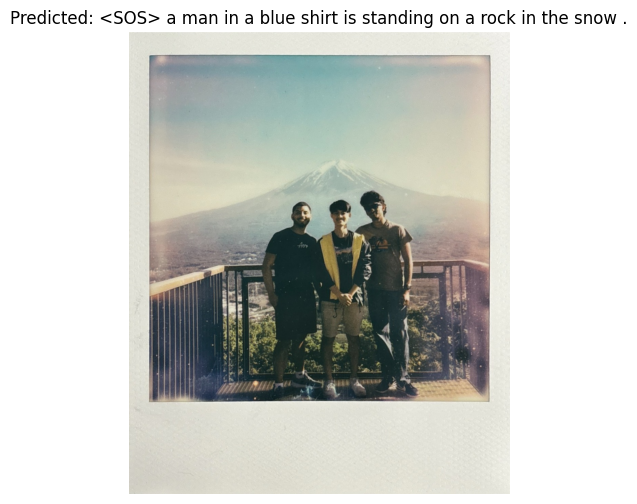

Image: IMG_7605.JPG
Predicted Caption: <SOS> a man in a black shirt is standing on a sidewalk with a <UNK> <UNK> .
-------------------------------------------


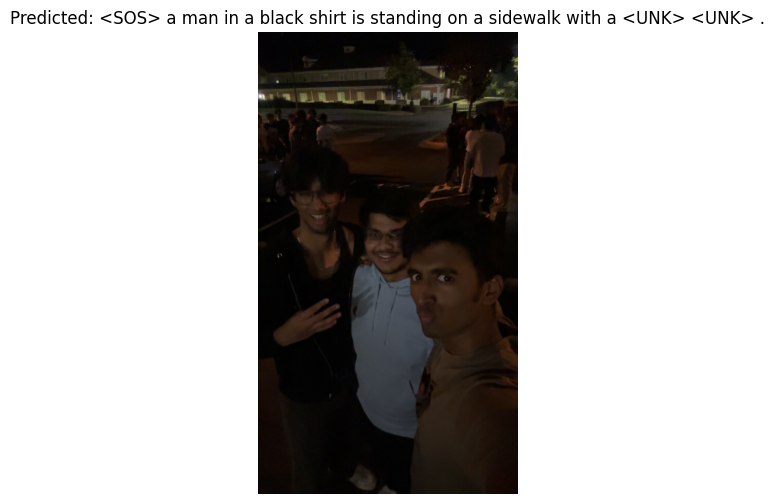

Image: IMG_8162.jpg
Predicted Caption: <SOS> a man in a black shirt is standing in front of a crowd of people .
-------------------------------------------


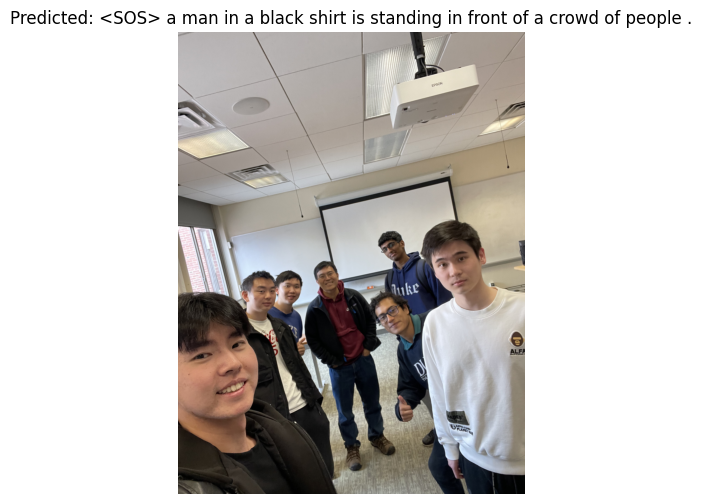

In [7]:
model.eval()  # ensure the model is in evaluation mode
my_imgs_folder = 'my_imgs'

supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
image_files = [f for f in os.listdir(my_imgs_folder) if f.lower().endswith(supported_extensions)]

print("Generating captions for images in 'my_imgs':")
for img_name in image_files:
    img_path = os.path.join(my_imgs_folder, img_name)
    try:
        image = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue

    # Transform and move image to device
    img = transform(image).unsqueeze(0).to(device)

    # Generate caption
    with torch.no_grad():
        pred_caption = model.caption_image(img, vocab)

    # Remove <EOS>, <PAD> from predicted caption
    pred_caption = [w for w in pred_caption if w not in ["<EOS>", "<PAD>"]]

    print("Image:", img_name)
    print("Predicted Caption:", " ".join(pred_caption))
    print("-------------------------------------------")

    # Display the image with the caption
    plt.figure(figsize=(6,6))
    plt.imshow(image)  # show the original PIL image
    plt.axis('off')
    plt.title("Predicted: " + " ".join(pred_caption))
    plt.show()

__Since transformer-based image captioning is far more computational and time intensive on my GPU, I have decided not to do that comparison. (resources are not permitted)__